# 1.导入必要的库

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

# 2.加载数据集

In [2]:
def load_wavelet_coeffs_from_npz(directory):
    data = []
    # 确保路径是正确的，这里可能需要根据你的运行环境进行调整
    for filename in os.listdir(directory):
        if filename.endswith('.npz'):
            file_path = os.path.join(directory, filename)
            coeffs = np.load(file_path)
            # 假设你的小波系数文件包含cA, cH, cV, cD四个键
            data.append(np.stack((coeffs['cA'], coeffs['cH'], coeffs['cV'], coeffs['cD']), axis=-1))
    return np.array(data)

# 请根据实际环境替换以下路径
source_coeffs_directory = 'E:\\wavelet\\wavelet coefficient\\source_coif1\\test'
noisy_coeffs_directory = 'E:\\wavelet\\wavelet coefficient\\Gauss_coif1\\test'

# 加载数据
clean_coeffs = load_wavelet_coeffs_from_npz(source_coeffs_directory)
noisy_coeffs = load_wavelet_coeffs_from_npz(noisy_coeffs_directory)

print("Loaded clean coefficients shape:", clean_coeffs.shape)
print("Loaded noisy coefficients shape:", noisy_coeffs.shape)


KeyError: 'cA is not a file in the archive'

# 3.探索数据集
在开始训练模型之前，探索一下你的数据集以确保数据被正确加载和处理。

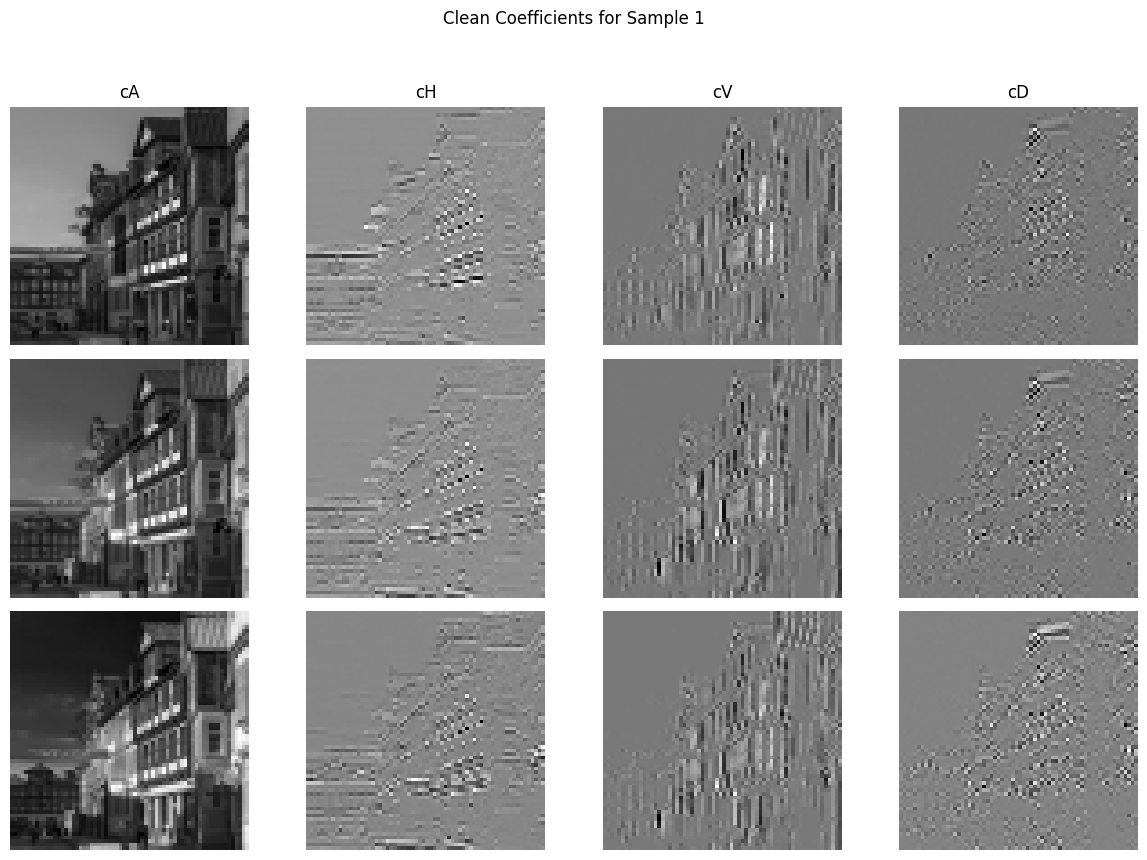

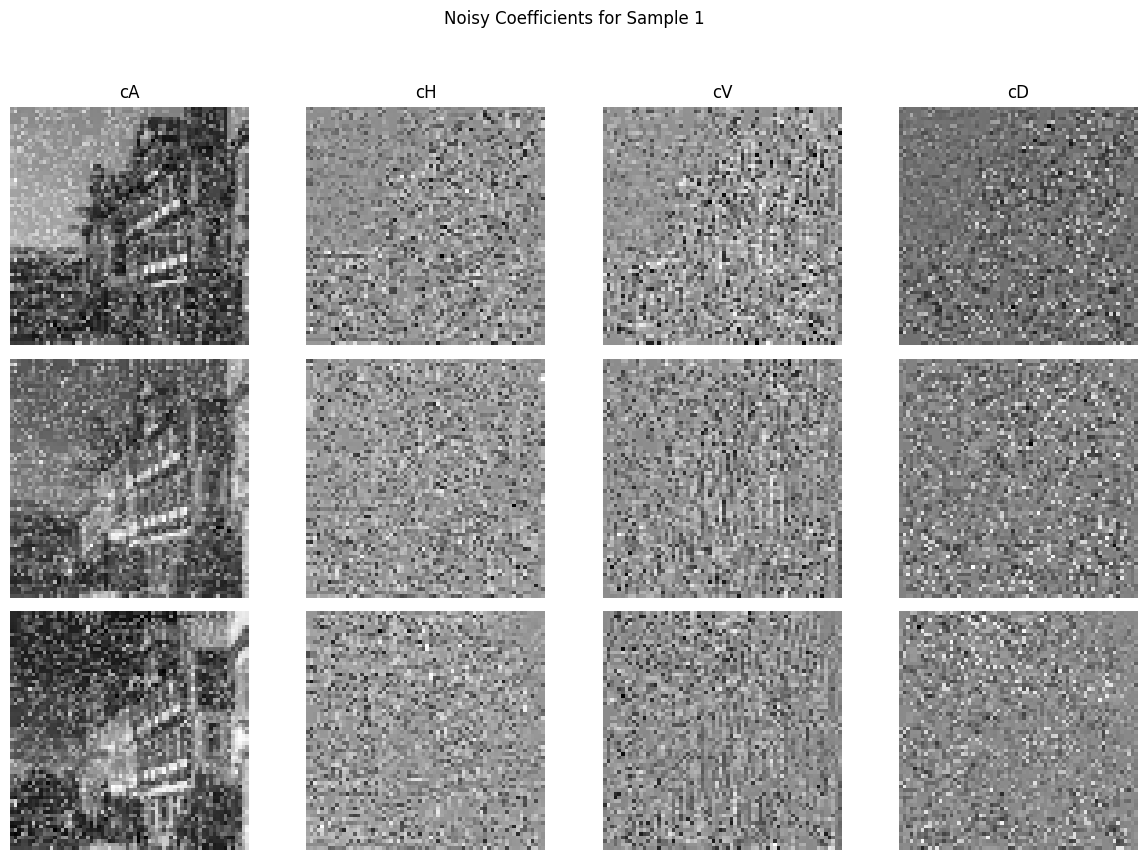

In [17]:
# # 显示数据集中的一个样本
# def display_coeffs(coeff_array, title="Coefficients"):
#     plt.figure(figsize=(10, 2.5))
#     for i, coeff in enumerate(['cA', 'cH', 'cV', 'cD']):
#         plt.subplot(1, 4, i+1)
#         plt.imshow(coeff_array[..., i], cmap='gray')
#         plt.title(coeff)
#         plt.axis('off')
#     plt.suptitle(title)
#     plt.show()
# 
# # 显示第一个样本的加噪系数和清洁系数
# display_coeffs(noisy_coeffs[0], "Noisy Coeffs")
# display_coeffs(clean_coeffs[0], "Clean Coeffs")

def visualize_wavelet_coeffs(coefficients, title="Coefficients"):
    """
    Visualizes the wavelet coefficients for a single sample.
    
    Parameters:
    - coefficients: A numpy array of shape (3, 69, 69, 4), representing the wavelet coefficients for 3 color channels.
    - title: A string for the plot title.
    """
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 9))
    coeff_types = ['cA', 'cH', 'cV', 'cD']
    
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            coeff_img = coefficients[i, :, :, j]
            ax.imshow(coeff_img, cmap='gray')
            if i == 0:
                ax.set_title(coeff_types[j])
            ax.axis('off')
    
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 选择一个样本进行展示，这里假设选择第一个样本
sample_index = 0
visualize_wavelet_coeffs(clean_coeffs[sample_index], "Clean Coefficients for Sample 1")
visualize_wavelet_coeffs(noisy_coeffs[sample_index], "Noisy Coefficients for Sample 1")

# 4.自定义裁剪层

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class CustomResizeLayer(Layer):
    def __init__(self, target_height, target_width, **kwargs):
        super(CustomResizeLayer, self).__init__(**kwargs)
        self.target_height = target_height
        self.target_width = target_width

    def call(self, inputs):
        # 计算批量大小和颜色通道数，用于之后的重塑
        batch_size, color_channels = tf.shape(inputs)[0], tf.shape(inputs)[1]
        
        # 重塑为 [batch_size * color_channels, height, width, channels]
        reshaped_inputs = tf.reshape(inputs, [-1, tf.shape(inputs)[2], tf.shape(inputs)[3], tf.shape(inputs)[4]])
        
        # 应用调整尺寸操作
        resized = tf.image.resize(reshaped_inputs, [self.target_height, self.target_width], method='bilinear')
        
        # 恢复到原始的5维格式 [batch_size, color_channels, new_height, new_width, channels]
        output_shape = [batch_size, color_channels, self.target_height, self.target_width, tf.shape(inputs)[4]]
        output = tf.reshape(resized, output_shape)
        return output

    def get_config(self):
        config = super(CustomResizeLayer, self).get_config()
        config.update({
            'target_height': self.target_height,
            'target_width': self.target_width
        })
        return config

# 5.构建模型

In [20]:
# from tensorflow.keras.layers import TimeDistributed
# # from tensorflow.keras.layers import Cropping2D
# 
# def build_autoencoder(input_shape):
#     inputs = Input(shape=input_shape)  # 输入形状为 (3, 69, 69, 4)
#     
#     # 使用 TimeDistributed 来保持颜色通道的独立性
#     x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(inputs)
#     x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
#     x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
#     encoded = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
#     
#     x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(encoded)
#     x = TimeDistributed(UpSampling2D((2, 2)))(x)
#     x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(x)
#     x = TimeDistributed(UpSampling2D((2, 2)))(x)
#     decode = TimeDistributed(Conv2D(4, (3, 3), activation='sigmoid', padding='same'))(x)
#     
#     # # 假设最后输出尺寸比目标尺寸大，使用Cropping2D进行调整
#     # # 这里假设需要从每边裁剪掉(1, 1)来匹配尺寸
#     # cropped = TimeDistributed(Cropping2D(cropping=((1, 1), (1, 1))))(decode)
#     
#     resized_output = CustomResizeLayer(target_height=69, target_width=69)(decode)
# 
#     autoencoder = Model(inputs, resized_output)
#     autoencoder.compile(optimizer='adam', loss='mse')
#     
#     return autoencoder
# 
# # 注意：这里我们直接使用原始的数据形状 (3, 69, 69, 4)
# model = build_autoencoder((3, 69, 69, 4))
# model.summary()

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, TimeDistributed, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import tensorflow as tf

# 自定义调整尺寸层省略，假设已定义

def build_autoencoder(input_shape, activation='relu'):
    inputs = Input(shape=input_shape)  # 输入形状为 (3, 69, 69, 4)
    
    # 使用 TimeDistributed 来保持颜色通道的独立性，激活函数通过参数指定
    x = TimeDistributed(Conv2D(32, (3, 3), activation=activation, padding='same'))(inputs)
    x = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation=activation, padding='same'))(x)
    encoded = TimeDistributed(MaxPooling2D((2, 2), padding='same'))(x)
    
    x = TimeDistributed(Conv2D(64, (3, 3), activation=activation, padding='same'))(encoded)
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(32, (3, 3), activation=activation, padding='same'))(x)
    x = TimeDistributed(UpSampling2D((2, 2)))(x)
    decoded = TimeDistributed(Conv2D(4, (3, 3), activation='linear', padding='same'))(x)
    
    resized_output = CustomResizeLayer(target_height=66, target_width=66)(decoded)

    autoencoder = Model(inputs, resized_output)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

# 使用原始的数据形状 (3, 69, 69, 4) 和 ReLU 激活函数
model = build_autoencoder((3, 66, 66, 4), activation='relu')
model.summary()

# # 如果想尝试其他激活函数，如 LeakyReLU
# model = build_autoencoder((3, 69, 69, 4), activation=tf.keras.layers.LeakyReLU(alpha=0.01))
# # 注意: 由于 LeakyReLU 不是一个字符串参数，你可能需要稍微调整模型构建的方式来兼容这种用法



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 66, 66, 4)]    0         
                                                                 
 time_distributed_27 (TimeD  (None, 3, 66, 66, 32)     1184      
 istributed)                                                     
                                                                 
 time_distributed_28 (TimeD  (None, 3, 33, 33, 32)     0         
 istributed)                                                     
                                                                 
 time_distributed_29 (TimeD  (None, 3, 33, 33, 64)     18496     
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, 3, 17, 17, 64)     0         
 istributed)                                               

# 5.训练模型

In [21]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(noisy_coeffs, clean_coeffs, test_size=0.2, random_state=42)

# 训练模型
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1)]
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/200
12/12 [==============================] - 4s 250ms/step - loss: 3839.5928 - val_loss: 1739.4996
Epoch 2/200
12/12 [==============================] - 3s 220ms/step - loss: 1680.9307 - val_loss: 1434.0419
Epoch 3/200
12/12 [==============================] - 3s 221ms/step - loss: 1436.8909 - val_loss: 1211.8171
Epoch 4/200
12/12 [==============================] - 3s 219ms/step - loss: 1232.7961 - val_loss: 1159.0732
Epoch 5/200
12/12 [==============================] - 3s 223ms/step - loss: 1158.7670 - val_loss: 1008.9011
Epoch 6/200
12/12 [==============================] - 3s 220ms/step - loss: 1088.5586 - val_loss: 1077.2039
Epoch 7/200
12/12 [==============================] - 3s 224ms/step - loss: 1068.5950 - val_loss: 990.0792
Epoch 8/200
12/12 [==============================] - 3s 220ms/step - loss: 1033.2480 - val_loss: 916.1980
Epoch 9/200
12/12 [==============================] - 3s 218ms/step - loss: 977.2608 - val_loss: 882.1750
Epoch 10/200
12/12 [=====================

1/1 [==============================] - 0s 115ms/step


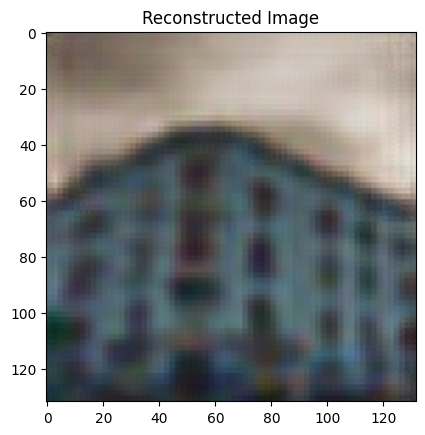

In [22]:
import pywt

# 假定X_test是包含验证样例的小波系数的数组
# 选择一个样本进行预测
sample_index = 0
sample_coeffs = X_test[sample_index:sample_index+1]  # 保持批次维度以适应模型输入
predicted_coeffs = model.predict(sample_coeffs)

# 将预测的小波系数转换为适用于逆变换的格式
# 注意：这假设predicted_coeffs是具有相应形状的小波系数
predicted_coeffs_reshaped = predicted_coeffs[0]  # 移除批次维度
cA = predicted_coeffs_reshaped[:, :, :, 0]
cH = predicted_coeffs_reshaped[:, :, :, 1]
cV = predicted_coeffs_reshaped[:, :, :, 2]
cD = predicted_coeffs_reshaped[:, :, :, 3]

# 对每个颜色通道进行逆小波变换
reconstructed_images = []
for i in range(cA.shape[0]):  # 遍历颜色通道
    coeffs = (cA[i], (cH[i], cV[i], cD[i]))
    reconstructed_image = pywt.idwt2(coeffs, 'haar')  # 使用与前向变换相同的小波
    reconstructed_images.append(reconstructed_image)

# 将重建的图像通道合并
reconstructed_image = np.stack(reconstructed_images, axis=-1)

# 显示重建的图像
plt.imshow(reconstructed_image.astype('uint8'))  # 确保图像数据类型适用于显示
plt.title("Reconstructed Image")
plt.show()